In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import os
project_path = '/content/drive/MyDrive/Labelled_Multiclass_Dataset'
os.chdir(project_path)

In [10]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
data = pd.read_csv('/content/drive/MyDrive/Labelled_Multiclass_Dataset/combined_data_with_okpVacc_modified.csv')

In [12]:
print(len(data))

125909


In [13]:
import xgboost as xgb
import sklearn

print("XGBoost version:", xgb.__version__)
print("Scikit-learn version:", sklearn.__version__)

XGBoost version: 2.1.4
Scikit-learn version: 1.1.3


In [14]:
data.columns

Index(['Unnamed: 0', 'device_id', 'session_id', 'src_ip', 'dst_ip', 'src_port',
       'dst_port', 'protocol', 'timestamp', 'flow_duration', 'flow_byts_s',
       'flow_pkts_s', 'fwd_pkts_s', 'bwd_pkts_s', 'tot_fwd_pkts',
       'tot_bwd_pkts', 'totlen_fwd_pkts', 'totlen_bwd_pkts', 'fwd_pkt_len_max',
       'fwd_pkt_len_min', 'fwd_pkt_len_mean', 'fwd_pkt_len_std',
       'bwd_pkt_len_max', 'bwd_pkt_len_min', 'bwd_pkt_len_mean',
       'bwd_pkt_len_std', 'pkt_len_max', 'pkt_len_min', 'pkt_len_mean',
       'pkt_len_std', 'pkt_len_var', 'fwd_header_len', 'bwd_header_len',
       'fwd_seg_size_min', 'fwd_act_data_pkts', 'flow_iat_mean',
       'flow_iat_max', 'flow_iat_min', 'flow_iat_std', 'fwd_iat_tot',
       'fwd_iat_max', 'fwd_iat_min', 'fwd_iat_mean', 'fwd_iat_std',
       'bwd_iat_tot', 'bwd_iat_max', 'bwd_iat_min', 'bwd_iat_mean',
       'bwd_iat_std', 'fwd_psh_flags', 'bwd_psh_flags', 'fwd_urg_flags',
       'bwd_urg_flags', 'fin_flag_cnt', 'syn_flag_cnt', 'rst_flag_cnt',
       

In [15]:
data.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
drop_columns = [
    "id"
   ]
data.drop(columns=drop_columns, inplace=True, errors='ignore')

In [16]:
data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce', format='%d-%m-%Y %H:%M')

In [17]:
# Ensure the index is of datetime type
if not pd.api.types.is_datetime64_any_dtype(data.index):
    data['time'] = pd.to_datetime(data['timestamp'])
    data.set_index('time', inplace=True)

In [18]:
# Check if the index is sorted
is_sorted = data.index.is_monotonic_increasing
print(f"Is the Timestamp index sorted? {is_sorted}")

Is the Timestamp index sorted? False


In [19]:
# If the index is not sorted, sort it
if not is_sorted:
    data.sort_index(inplace=True)
    print("Timestamp index was not sorted. It has now been sorted.")

Timestamp index was not sorted. It has now been sorted.


In [20]:
# Check if the index is sorted
is_sorted = data.index.is_monotonic_increasing
print(f"Is the Timestamp index sorted? {is_sorted}")

Is the Timestamp index sorted? True


In [21]:
# Identifying missing values
missing_val = data.isna().sum()
print(missing_val.loc[missing_val > 0])

Series([], dtype: int64)


In [22]:
# Checking for infinity values
numeric_cols = data.select_dtypes(include = np.number).columns
inf_count = np.isinf(data[numeric_cols]).sum()
print(inf_count[inf_count > 0])

Series([], dtype: int64)


In [23]:
# Replacing any infinite values (positive or negative) with NaN (not a number)
print(f'Initial missing values: {data.isna().sum().sum()}')

data.replace([np.inf, -np.inf], np.nan, inplace = True)

print(f'Missing values after processing infinite values: {data.isna().sum().sum()}')

Initial missing values: 0
Missing values after processing infinite values: 0


In [24]:
# Define window size  and step size
window_size = pd.Timedelta('5s')  # 5-second window size
step_size = pd.Timedelta('3s')   # 3-second sliding step

In [25]:
# Ensure 'timestamp' is included in the dataset
data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce', format='%d-%m-%Y %H:%M')

# Aggregate session-based features and add timestamp information
session_data = data.groupby(['src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol']).agg(
    # Session-based aggregations
    flow_duration=('flow_duration', 'sum'),
    total_forward_packets=('tot_fwd_pkts', 'sum'),
    total_backward_packets=('tot_bwd_pkts', 'sum'),
    total_bytes_forward=('totlen_fwd_pkts', 'sum'),
    total_bytes_backward=('totlen_bwd_pkts', 'sum'),
    mean_packet_length_forward=('fwd_pkt_len_mean', 'mean'),
    mean_packet_length_backward=('bwd_pkt_len_mean', 'mean'),
    packet_size_mean=('pkt_len_mean', 'mean'),
    flow_iat_mean=('flow_iat_mean', 'mean'),
    down_up_ratio=('down_up_ratio', 'mean'),
    subflow_fwd_pkts=('subflow_fwd_pkts', 'sum'),
    subflow_bwd_pkts=('subflow_bwd_pkts', 'sum'),
    subflow_fwd_byts=('subflow_fwd_byts', 'sum'),
    subflow_bwd_byts=('subflow_bwd_byts', 'sum'),

    # Direction-specific aggregations (Forward flows)
    fwd_pkt_len_mean=('fwd_pkt_len_mean', 'mean'),
    fwd_pkt_len_max=('fwd_pkt_len_max', 'max'),
    fwd_pkt_len_min=('fwd_pkt_len_min', 'min'),
    fwd_pkt_len_std=('fwd_pkt_len_std', 'std'),
    fwd_iat_mean=('fwd_iat_mean', 'mean'),
    fwd_iat_max=('fwd_iat_max', 'max'),
    fwd_iat_min=('fwd_iat_min', 'min'),
    fwd_iat_tot=('fwd_iat_tot', 'sum'),
    fwd_blk_rate_avg=('fwd_blk_rate_avg', 'mean'),

    # Direction-specific aggregations (Backward flows)
    bwd_pkt_len_mean=('bwd_pkt_len_mean', 'mean'),
    bwd_pkt_len_max=('bwd_pkt_len_max', 'max'),
    bwd_pkt_len_min=('bwd_pkt_len_min', 'min'),
    bwd_pkt_len_std=('bwd_pkt_len_std', 'std'),
    bwd_iat_mean=('bwd_iat_mean', 'mean'),
    bwd_iat_max=('bwd_iat_max', 'max'),
    bwd_iat_min=('bwd_iat_min', 'min'),
    bwd_iat_tot=('bwd_iat_tot', 'sum'),
    bwd_blk_rate_avg=('bwd_blk_rate_avg', 'mean'),

    # Timestamp info: min and max timestamp per session
    start_time=('timestamp', 'min'),
    end_time=('timestamp', 'max')
)

# calculate total packets and total bytes after the aggregation
session_data['total_packets'] = session_data['total_forward_packets'] + session_data['total_backward_packets']
session_data['total_bytes'] = session_data['total_bytes_forward'] + session_data['total_bytes_backward']

session_data = session_data.reset_index()

In [26]:
session_data.head()

,src_ip,dst_ip,src_port,dst_port,protocol,flow_duration,total_forward_packets,total_backward_packets,total_bytes_forward,total_bytes_backward,...,bwd_pkt_len_std,bwd_iat_mean,bwd_iat_max,bwd_iat_min,bwd_iat_tot,bwd_blk_rate_avg,start_time,end_time,total_packets,total_bytes
0,0.0.0.0,255.255.255.255,68,67,17,711407852,89,0,30236,0,...,0.0,0.0,0,0,0,0.0,2024-08-13 08:01:00,2024-08-26 12:34:00,89,30236
1,13.107.246.41,192.168.1.192,443,50272,6,10256,4,3,303,210,...,NaN,2448.5,3921,976,4897,0.0,2024-08-13 08:00:00,2024-08-13 08:00:00,7,513
2,13.107.42.18,192.168.1.192,443,33066,6,0,1,0,54,0,...,NaN,0.0,0,0,0,0.0,2024-08-16 08:05:00,2024-08-16 08:05:00,1,54
3,13.107.42.18,192.168.1.192,443,36978,6,0,1,0,54,0,...,NaN,0.0,0,0,0,0.0,2024-08-15 07:02:00,2024-08-15 07:02:00,1,54
4,13.107.42.18,192.168.1.192,443,45660,6,0,1,0,54,0,...,NaN,0.0,0,0,0,0.0,2024-08-14 08:32:00,2024-08-14 08:32:00,1,54


In [27]:
import scipy.stats

# entropy calculation
def entropy(column):
    counts = column.value_counts(normalize=True)
    return scipy.stats.entropy(counts)

# Time-Based Sliding Window Aggregation
def sliding_window_aggregation(data, window_size, step_size):
    window_aggregates = []

    # Generate the start times using pd.date_range
    start_times = pd.date_range(start=data.index.min(), end=data.index.max(), freq=step_size)

    # Iterate over each time window
    for start_time in start_times:
        end_time = start_time + window_size
        window = data[(data.index >= start_time) & (data.index < end_time)]

        if len(window) == 0:
            continue

        window.loc[:, 'timestamp'] = pd.to_datetime(window['timestamp'])

        # Flow rate features
        duration = (window['timestamp'].max() - window['timestamp'].min()).total_seconds() + 1e-9
        flow_rate_features = {
            'flow_rate_packets_window': len(window) / duration,
            'flow_rate_bytes_window': window['totlen_fwd_pkts'].sum() / duration,
        }

        # Directional ratio features
        directional_features = {
            'flow_direction_ratio_window': window['tot_fwd_pkts'].sum() / (window['tot_bwd_pkts'].sum() + 1),
            'byte_direction_ratio_window': window['totlen_fwd_pkts'].sum() / (window['totlen_bwd_pkts'].sum() + 1),
        }

        # Entropy-based features
        entropy_features = {
            'src_ip_entropy_window': entropy(window['src_ip']),
            'dst_ip_entropy_window': entropy(window['dst_ip']),
        }

        aggregated = {
            'start_time': start_time,
            'end_time': end_time,
            'total_forward_packets_window': window['tot_fwd_pkts'].sum(),
            'total_backward_packets_window': window['tot_bwd_pkts'].sum(),
            'total_forward_bytes_window': window['totlen_fwd_pkts'].sum(),
            'total_backward_bytes_window': window['totlen_bwd_pkts'].sum(),
            'average_packet_size_fwd_window': window['fwd_pkt_len_mean'].mean(),
            'average_packet_size_bwd_window': window['bwd_pkt_len_mean'].mean(),
            'flow_duration_window': window['flow_duration'].sum(),
            'packet_count_window': len(window),
            'mean_iat_fwd_window': window['fwd_iat_mean'].mean(),
            'stddev_iat_fwd_window': window['fwd_iat_std'].mean(),
            'min_iat_fwd_window': window['fwd_iat_min'].min(),
            'max_iat_fwd_window': window['fwd_iat_max'].max(),
            'mean_iat_bwd_window': window['bwd_iat_mean'].mean(),
            'stddev_iat_bwd_window': window['bwd_iat_std'].mean(),
            'min_iat_bwd_window': window['bwd_iat_min'].min(),
            'max_iat_bwd_window': window['bwd_iat_max'].max(),
            **flow_rate_features,
            **directional_features,
            **entropy_features
        }

        window_aggregates.append(aggregated)

    return pd.DataFrame(window_aggregates)

In [28]:
# Apply sliding window aggregation
sliding_windows_data = sliding_window_aggregation(data, window_size, step_size)

In [29]:
sliding_windows_data.columns

Index(['start_time', 'end_time', 'total_forward_packets_window',
       'total_backward_packets_window', 'total_forward_bytes_window',
       'total_backward_bytes_window', 'average_packet_size_fwd_window',
       'average_packet_size_bwd_window', 'flow_duration_window',
       'packet_count_window', 'mean_iat_fwd_window', 'stddev_iat_fwd_window',
       'min_iat_fwd_window', 'max_iat_fwd_window', 'mean_iat_bwd_window',
       'stddev_iat_bwd_window', 'min_iat_bwd_window', 'max_iat_bwd_window',
       'flow_rate_packets_window', 'flow_rate_bytes_window',
       'flow_direction_ratio_window', 'byte_direction_ratio_window',
       'src_ip_entropy_window', 'dst_ip_entropy_window'],
      dtype='object')

In [30]:
sliding_windows_data.head()

,start_time,end_time,total_forward_packets_window,total_backward_packets_window,total_forward_bytes_window,total_backward_bytes_window,average_packet_size_fwd_window,average_packet_size_bwd_window,flow_duration_window,packet_count_window,...,mean_iat_bwd_window,stddev_iat_bwd_window,min_iat_bwd_window,max_iat_bwd_window,flow_rate_packets_window,flow_rate_bytes_window,flow_direction_ratio_window,byte_direction_ratio_window,src_ip_entropy_window,dst_ip_entropy_window
0,2024-08-13 08:00:00,2024-08-13 08:00:05,261,158,28218,11769,64.239935,56.293254,1370937322,126,...,1.125551e+06,7.130830e+05,0,55409580,1.260000e+11,2.821800e+13,1.641509,2.397451,0.567192,0.971967
1,2024-08-13 08:00:57,2024-08-13 08:01:02,42,9,6232,671,134.525210,8.519608,208424228,17,...,2.853903e+06,3.595447e+05,0,46586112,1.700000e+10,6.232000e+12,4.200000,9.273810,0.997615,0.997615
2,2024-08-13 08:01:00,2024-08-13 08:01:05,42,9,6232,671,134.525210,8.519608,208424228,17,...,2.853903e+06,3.595447e+05,0,46586112,1.700000e+10,6.232000e+12,4.200000,9.273810,0.997615,0.997615
3,2024-08-13 08:01:57,2024-08-13 08:02:02,92,6,15528,492,127.553571,5.125000,460103011,16,...,7.510527e+05,1.195037e+06,0,49999970,1.600000e+10,1.552800e+13,13.142857,31.496957,1.124036,0.831403
4,2024-08-13 08:02:00,2024-08-13 08:02:05,92,6,15528,492,127.553571,5.125000,460103011,16,...,7.510527e+05,1.195037e+06,0,49999970,1.600000e+10,1.552800e+13,13.142857,31.496957,1.124036,0.831403


In [31]:
# Merge sliding window and session data on overlapping time intervals
aggregated_data = pd.merge_asof(
    sliding_windows_data.sort_values('start_time'),
    session_data.sort_values('start_time'),
    left_on='start_time',
    right_on='start_time',
    direction='backward'
)

In [32]:
aggregated_data.columns

Index(['start_time', 'end_time_x', 'total_forward_packets_window',
       'total_backward_packets_window', 'total_forward_bytes_window',
       'total_backward_bytes_window', 'average_packet_size_fwd_window',
       'average_packet_size_bwd_window', 'flow_duration_window',
       'packet_count_window', 'mean_iat_fwd_window', 'stddev_iat_fwd_window',
       'min_iat_fwd_window', 'max_iat_fwd_window', 'mean_iat_bwd_window',
       'stddev_iat_bwd_window', 'min_iat_bwd_window', 'max_iat_bwd_window',
       'flow_rate_packets_window', 'flow_rate_bytes_window',
       'flow_direction_ratio_window', 'byte_direction_ratio_window',
       'src_ip_entropy_window', 'dst_ip_entropy_window', 'src_ip', 'dst_ip',
       'src_port', 'dst_port', 'protocol', 'flow_duration',
       'total_forward_packets', 'total_backward_packets',
       'total_bytes_forward', 'total_bytes_backward',
       'mean_packet_length_forward', 'mean_packet_length_backward',
       'packet_size_mean', 'flow_iat_mean', 'down_u

In [33]:
print(len(session_data))
print(len(sliding_windows_data))
print(len(aggregated_data))

58852
9595
9595


In [34]:
print(session_data.shape)
print(sliding_windows_data.shape)
print(aggregated_data.shape)

(58852, 41)
(9595, 24)
(9595, 64)


In [35]:
# Select columns (src_ip, dst_ip, 'src_port', 'dst_port', 'protocol', 'Label') from the original DataFrame
original_subset = data[['src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol', 'Label']].drop_duplicates()

In [36]:
# Perform the merge
aggregated_data = aggregated_data.merge(original_subset, on=['src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol'], how='left')

In [37]:
num_rows = aggregated_data.shape[0]
print(f"Number of rows in aggregated_data: {num_rows}")

Number of rows in aggregated_data: 9595


In [38]:
# Check for Class Imbalance
print(aggregated_data['Label'].value_counts())

Label
Benign        9263
TCPAttack      108
UDPAttack      106
HTTPAttack      66
XMasAttack      52
Name: count, dtype: int64


In [39]:
aggregated_data.head()

,start_time,end_time_x,total_forward_packets_window,total_backward_packets_window,total_forward_bytes_window,total_backward_bytes_window,average_packet_size_fwd_window,average_packet_size_bwd_window,flow_duration_window,packet_count_window,...,bwd_pkt_len_std,bwd_iat_mean,bwd_iat_max,bwd_iat_min,bwd_iat_tot,bwd_blk_rate_avg,end_time_y,total_packets,total_bytes,Label
0,2024-08-13 08:00:00,2024-08-13 08:00:05,261,158,28218,11769,64.239935,56.293254,1370937322,126,...,NaN,0.000000e+00,0,0,0,0.0,2024-08-13 08:00:00,2,114,XMasAttack
1,2024-08-13 08:00:57,2024-08-13 08:01:02,42,9,6232,671,134.525210,8.519608,208424228,17,...,NaN,0.000000e+00,0,0,0,0.0,2024-08-13 08:00:00,2,114,XMasAttack
2,2024-08-13 08:01:00,2024-08-13 08:01:05,42,9,6232,671,134.525210,8.519608,208424228,17,...,NaN,0.000000e+00,0,0,0,0.0,2024-08-13 08:01:00,1,121,Benign
3,2024-08-13 08:01:57,2024-08-13 08:02:02,92,6,15528,492,127.553571,5.125000,460103011,16,...,NaN,0.000000e+00,0,0,0,0.0,2024-08-13 08:01:00,1,121,Benign
4,2024-08-13 08:02:00,2024-08-13 08:02:05,92,6,15528,492,127.553571,5.125000,460103011,16,...,66.085113,1.689252e+07,54607868,4,42342244580,0.0,2024-08-16 15:58:00,6152,636857,Benign


In [40]:
# Correlation among features in the aggregated dataset

In [41]:
copy_corr = pd.DataFrame(aggregated_data)

In [42]:
# Copy the DataFrame
aggregated_copy = copy_corr.copy()

In [43]:
aggregated_copy.head()

,start_time,end_time_x,total_forward_packets_window,total_backward_packets_window,total_forward_bytes_window,total_backward_bytes_window,average_packet_size_fwd_window,average_packet_size_bwd_window,flow_duration_window,packet_count_window,...,bwd_pkt_len_std,bwd_iat_mean,bwd_iat_max,bwd_iat_min,bwd_iat_tot,bwd_blk_rate_avg,end_time_y,total_packets,total_bytes,Label
0,2024-08-13 08:00:00,2024-08-13 08:00:05,261,158,28218,11769,64.239935,56.293254,1370937322,126,...,NaN,0.000000e+00,0,0,0,0.0,2024-08-13 08:00:00,2,114,XMasAttack
1,2024-08-13 08:00:57,2024-08-13 08:01:02,42,9,6232,671,134.525210,8.519608,208424228,17,...,NaN,0.000000e+00,0,0,0,0.0,2024-08-13 08:00:00,2,114,XMasAttack
2,2024-08-13 08:01:00,2024-08-13 08:01:05,42,9,6232,671,134.525210,8.519608,208424228,17,...,NaN,0.000000e+00,0,0,0,0.0,2024-08-13 08:01:00,1,121,Benign
3,2024-08-13 08:01:57,2024-08-13 08:02:02,92,6,15528,492,127.553571,5.125000,460103011,16,...,NaN,0.000000e+00,0,0,0,0.0,2024-08-13 08:01:00,1,121,Benign
4,2024-08-13 08:02:00,2024-08-13 08:02:05,92,6,15528,492,127.553571,5.125000,460103011,16,...,66.085113,1.689252e+07,54607868,4,42342244580,0.0,2024-08-16 15:58:00,6152,636857,Benign


In [44]:
drop_columns = [
    "start_time", "end_time_x", "src_ip", "dst_ip", "end_time_y", "Label",
   ]
aggregated_copy.drop(columns=drop_columns, inplace=True, errors='ignore')

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assume `aggregated_data` is your DataFrame
# Step 1: Compute the Correlation Matrix
correlation_matrix = aggregated_copy.corr()

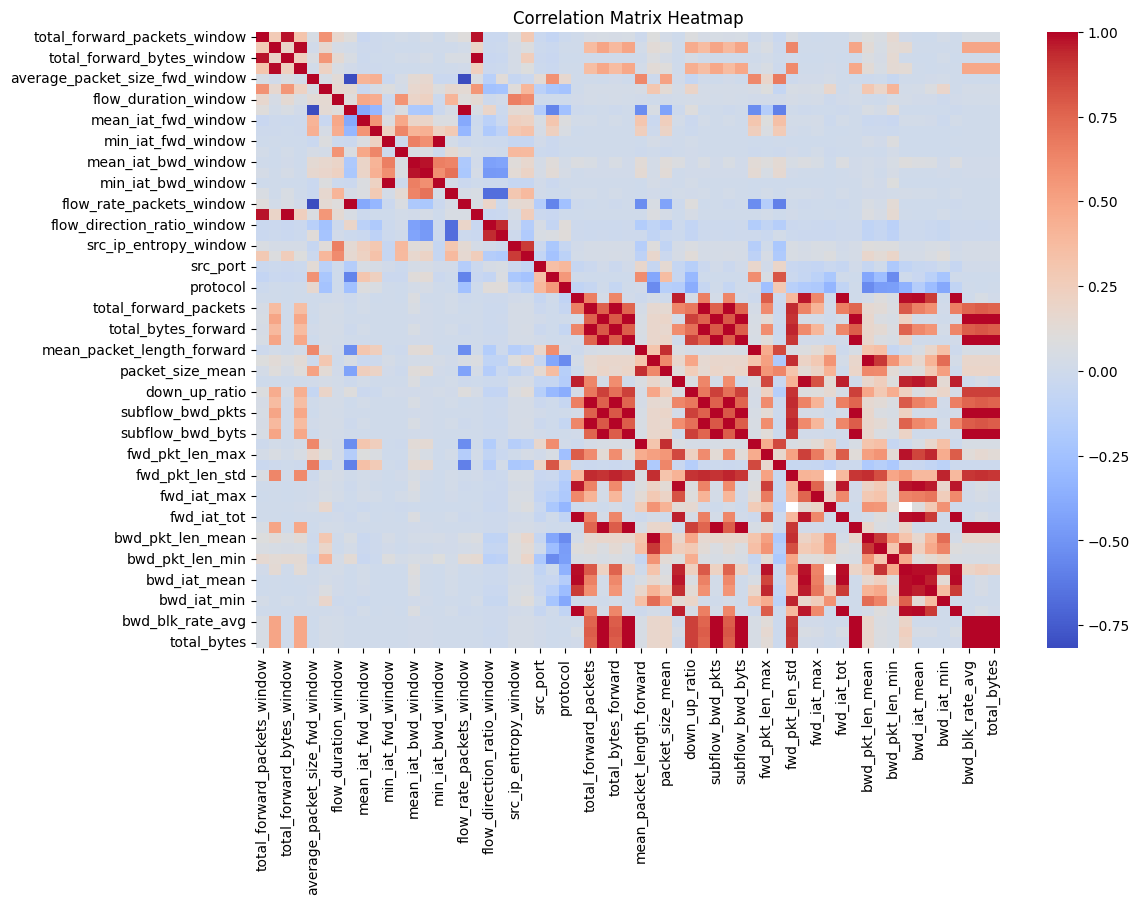

In [46]:
# Step 2: Plot the Correlation Matrix as a Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [47]:
# Step 3: Identify Highly Correlated Features
# Set a correlation threshold
correlation_threshold = 0.9

In [48]:
# Find feature pairs with correlation above the threshold
high_correlation_pairs = []
for i in range(correlation_matrix.shape[0]):
    for j in range(i + 1, correlation_matrix.shape[1]):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            feature_1 = correlation_matrix.index[i]
            feature_2 = correlation_matrix.columns[j]
            correlation_value = correlation_matrix.iloc[i, j]
            high_correlation_pairs.append((feature_1, feature_2, correlation_value))

# Print highly correlated feature pairs
print("Highly Correlated Features (Threshold > 0.9):")
for feature_1, feature_2, correlation_value in high_correlation_pairs:
    print(f"{feature_1} and {feature_2}: Correlation = {correlation_value:.2f}")


Highly Correlated Features (Threshold > 0.9):
total_forward_packets_window and total_forward_bytes_window: Correlation = 0.97
total_forward_packets_window and flow_rate_bytes_window: Correlation = 0.97
total_backward_packets_window and total_backward_bytes_window: Correlation = 0.99
total_forward_bytes_window and flow_rate_bytes_window: Correlation = 1.00
packet_count_window and flow_rate_packets_window: Correlation = 1.00
min_iat_fwd_window and min_iat_bwd_window: Correlation = 1.00
mean_iat_bwd_window and stddev_iat_bwd_window: Correlation = 0.97
flow_direction_ratio_window and byte_direction_ratio_window: Correlation = 0.93
flow_duration and flow_iat_mean: Correlation = 0.95
flow_duration and fwd_iat_mean: Correlation = 0.97
flow_duration and fwd_iat_tot: Correlation = 1.00
flow_duration and bwd_pkt_len_std: Correlation = 0.98
flow_duration and bwd_iat_mean: Correlation = 0.99
flow_duration and bwd_iat_tot: Correlation = 1.00
total_forward_packets and total_bytes_forward: Correlatio

In [49]:
drop_columns = [
    "start_time", "end_time_x", "src_ip", "dst_ip", "end_time_y"
   ]
aggregated_data.drop(columns=drop_columns, inplace=True, errors='ignore')

In [50]:
# Standardizing the dataset
from sklearn.preprocessing import StandardScaler

features = aggregated_data.drop('Label', axis = 1)
attacks = aggregated_data['Label']

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [51]:
# Identifying missing values
missing_val = aggregated_data.isna().sum()
print(missing_val.loc[missing_val > 0])

fwd_pkt_len_std    4071
bwd_pkt_len_std    4071
dtype: int64


In [52]:
# selecting numeric attributes columns from aggregated_data
num_col = list(aggregated_data.select_dtypes(include='number').columns)
print(num_col)

['total_forward_packets_window', 'total_backward_packets_window', 'total_forward_bytes_window', 'total_backward_bytes_window', 'average_packet_size_fwd_window', 'average_packet_size_bwd_window', 'flow_duration_window', 'packet_count_window', 'mean_iat_fwd_window', 'stddev_iat_fwd_window', 'min_iat_fwd_window', 'max_iat_fwd_window', 'mean_iat_bwd_window', 'stddev_iat_bwd_window', 'min_iat_bwd_window', 'max_iat_bwd_window', 'flow_rate_packets_window', 'flow_rate_bytes_window', 'flow_direction_ratio_window', 'byte_direction_ratio_window', 'src_ip_entropy_window', 'dst_ip_entropy_window', 'src_port', 'dst_port', 'protocol', 'flow_duration', 'total_forward_packets', 'total_backward_packets', 'total_bytes_forward', 'total_bytes_backward', 'mean_packet_length_forward', 'mean_packet_length_backward', 'packet_size_mean', 'flow_iat_mean', 'down_up_ratio', 'subflow_fwd_pkts', 'subflow_bwd_pkts', 'subflow_fwd_byts', 'subflow_bwd_byts', 'fwd_pkt_len_mean', 'fwd_pkt_len_max', 'fwd_pkt_len_min', 'fwd

In [53]:
# Checking for infinity or NaN values and replacing them with the median value of the column
aggregated_data.replace([np.inf, -np.inf], np.nan, inplace=True)
for col in num_col:
    if aggregated_data[col].isnull().sum() > 0:
        median_value = aggregated_data[col].median()
        aggregated_data[col] = aggregated_data[col].fillna(median_value)  # Direct assignment to avoid warning

In [54]:
# Identifying missing values
missing_val = aggregated_data.isna().sum()
print(missing_val.loc[missing_val > 0])

Series([], dtype: int64)


In [55]:
# Standardizing the dataset
from sklearn.preprocessing import StandardScaler

features = aggregated_data.drop('Label', axis = 1)
attacks = aggregated_data['Label']

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [56]:
from sklearn.decomposition import IncrementalPCA

size = len(features.columns) // 2
ipca = IncrementalPCA(n_components = size, batch_size = 500)
for batch in np.array_split(scaled_features, len(features) // 500):
    ipca.partial_fit(batch)

print(f'information retained: {sum(ipca.explained_variance_ratio_):.2%}')

information retained: 99.84%


In [57]:
# Exploring Explained Variance
print(ipca.explained_variance_ratio_)

[0.25306658 0.15026115 0.11047835 0.09652003 0.07734918 0.0575517
 0.04917948 0.03746962 0.02487485 0.02160702 0.01820515 0.01539402
 0.01447542 0.01005905 0.00953838 0.0089188  0.00814917 0.00721134
 0.00640659 0.00583491 0.00450088 0.00388789 0.00187841 0.00183527
 0.00127876 0.00082997 0.0007489  0.00047529 0.0004353 ]


In [58]:
# Exploring our PCA Data
expl_var = ipca.explained_variance_ratio_
df_expl_var = pd.DataFrame(
    data=zip(range(1, len(expl_var) + 1), expl_var, expl_var.cumsum()),
    columns=['IPCA', 'Explained Variance (%)', 'Total Explained Variance (%)']
    ).set_index('IPCA').mul(100).round(1)
print(df_expl_var)

      Explained Variance (%)  Total Explained Variance (%)
IPCA                                                      
1                       25.3                          25.3
2                       15.0                          40.3
3                       11.0                          51.4
4                        9.7                          61.0
5                        7.7                          68.8
6                        5.8                          74.5
7                        4.9                          79.4
8                        3.7                          83.2
9                        2.5                          85.7
10                       2.2                          87.8
11                       1.8                          89.7
12                       1.5                          91.2
13                       1.4                          92.6
14                       1.0                          93.6
15                       1.0                          94

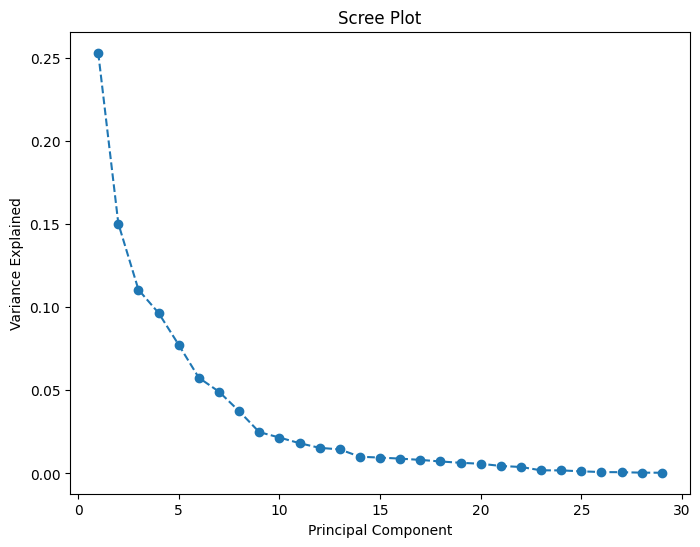

In [59]:
# Assuming pca is the fitted PCA model
explained_variance_ratio = ipca.explained_variance_ratio_

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

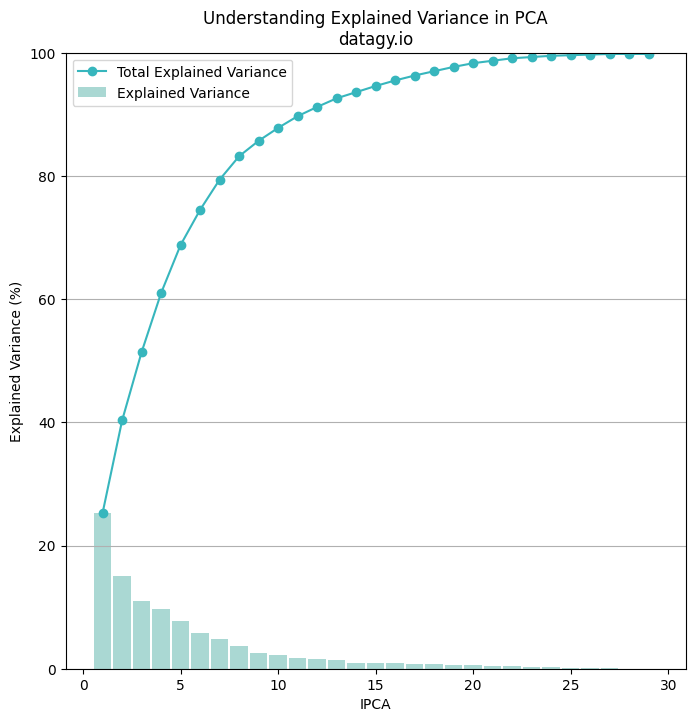

In [60]:
fig, ax = plt.subplots(figsize=(8,8))
ax.bar(x=df_expl_var.index, height=df_expl_var['Explained Variance (%)'], label='Explained Variance', width=0.9, color='#AAD8D3')
ax.plot(df_expl_var['Total Explained Variance (%)'], label='Total Explained Variance', marker='o', c='#37B6BD')

plt.ylim(0, 100)
plt.ylabel('Explained Variance (%)')
plt.xlabel('IPCA')
plt.grid(True, axis='y')
plt.title('Understanding Explained Variance in PCA\ndatagy.io')
plt.legend()

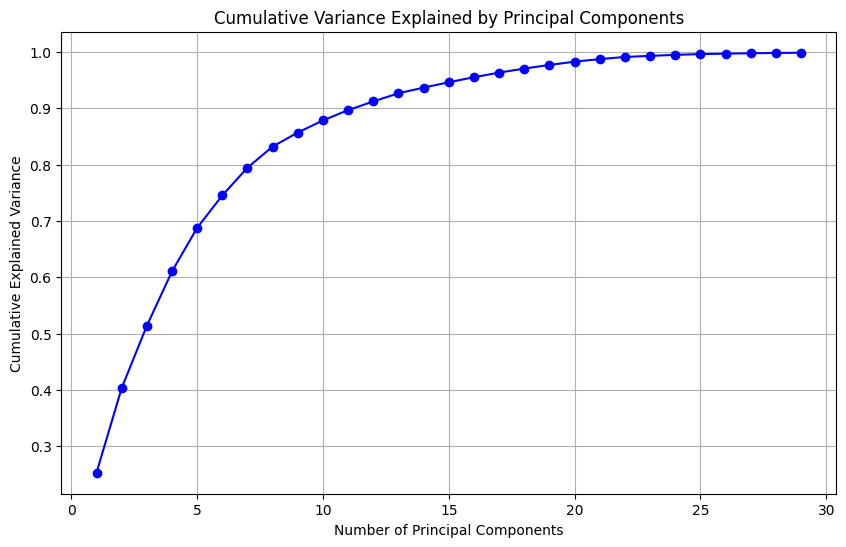

In [61]:
# Variance Explained Plot
cumulative_variance = np.cumsum(ipca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='b')
plt.title('Cumulative Variance Explained by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

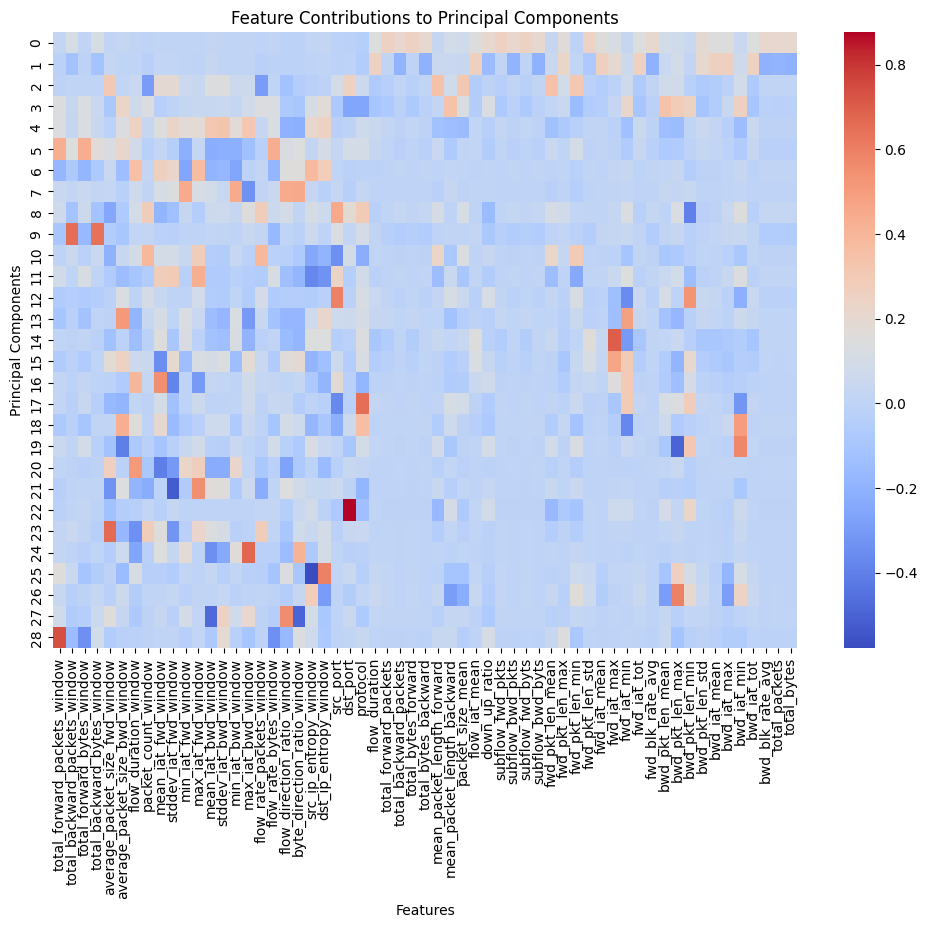

In [62]:
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(ipca.components_, cmap='coolwarm', annot=False, xticklabels=features.columns)
plt.title('Feature Contributions to Principal Components')
plt.xlabel('Features')
plt.ylabel('Principal Components')
plt.show()

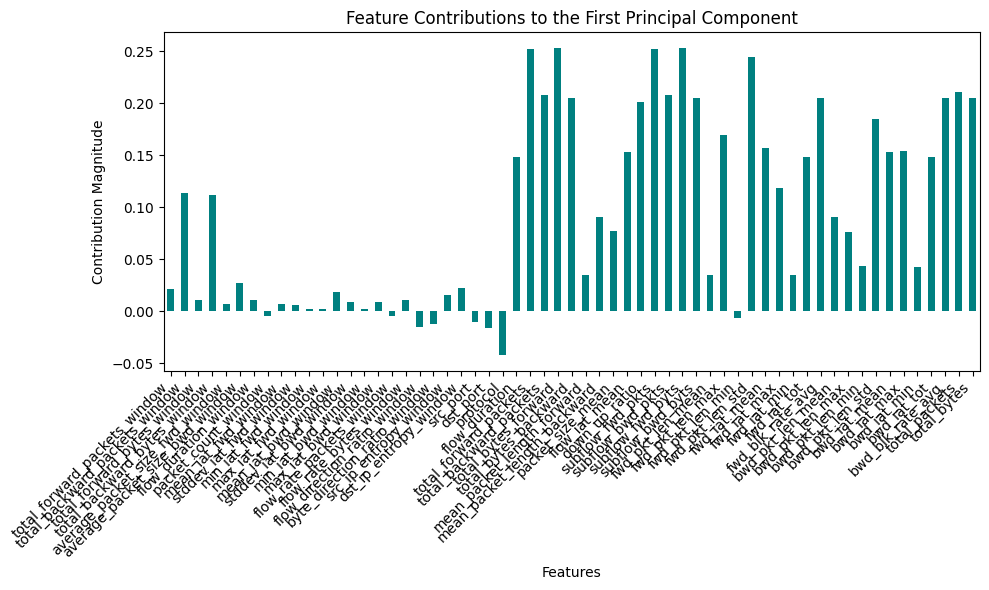

In [63]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert PCA components to a DataFrame
components_df = pd.DataFrame(ipca.components_, columns=features.columns)

# Plot the contributions of features to the first principal component as a bar chart
plt.figure(figsize=(10, 6))
components_df.iloc[0].plot(kind='bar', color='teal')
plt.title('Feature Contributions to the First Principal Component')
plt.ylabel('Contribution Magnitude')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [64]:
# Convert components to a DataFrame and round the values for better readability
components_table = pd.DataFrame(ipca.components_, columns=features.columns).round(2)

# Display as a styled table
components_table.style.background_gradient(cmap='coolwarm').set_caption('Feature Contributions to Principal Components')

,total_forward_packets_window,total_backward_packets_window,total_forward_bytes_window,total_backward_bytes_window,average_packet_size_fwd_window,average_packet_size_bwd_window,flow_duration_window,packet_count_window,mean_iat_fwd_window,stddev_iat_fwd_window,min_iat_fwd_window,max_iat_fwd_window,mean_iat_bwd_window,stddev_iat_bwd_window,min_iat_bwd_window,max_iat_bwd_window,flow_rate_packets_window,flow_rate_bytes_window,flow_direction_ratio_window,byte_direction_ratio_window,src_ip_entropy_window,dst_ip_entropy_window,src_port,dst_port,protocol,flow_duration,total_forward_packets,total_backward_packets,total_bytes_forward,total_bytes_backward,mean_packet_length_forward,mean_packet_length_backward,packet_size_mean,flow_iat_mean,down_up_ratio,subflow_fwd_pkts,subflow_bwd_pkts,subflow_fwd_byts,subflow_bwd_byts,fwd_pkt_len_mean,fwd_pkt_len_max,fwd_pkt_len_min,fwd_pkt_len_std,fwd_iat_mean,fwd_iat_max,fwd_iat_min,fwd_iat_tot,fwd_blk_rate_avg,bwd_pkt_len_mean,bwd_pkt_len_max,bwd_pkt_len_min,bwd_pkt_len_std,bwd_iat_mean,bwd_iat_max,bwd_iat_min,bwd_iat_tot,bwd_blk_rate_avg,total_packets,total_bytes
0,0.020000,0.110000,0.010000,0.110000,0.010000,0.030000,0.010000,-0.000000,0.010000,0.010000,0.000000,0.000000,0.020000,0.010000,0.000000,0.010000,-0.000000,0.010000,-0.020000,-0.010000,0.020000,0.020000,-0.010000,-0.020000,-0.040000,0.150000,0.250000,0.210000,0.250000,0.200000,0.040000,0.090000,0.080000,0.150000,0.200000,0.250000,0.210000,0.250000,0.200000,0.040000,0.170000,-0.010000,0.240000,0.160000,0.120000,0.030000,0.150000,0.200000,0.090000,0.080000,0.040000,0.180000,0.150000,0.150000,0.040000,0.150000,0.200000,0.210000,0.210000
1,-0.020000,-0.120000,-0.010000,-0.120000,0.030000,0.010000,0.000000,-0.020000,0.020000,0.010000,0.000000,0.000000,0.030000,0.010000,0.000000,0.010000,-0.020000,-0.010000,-0.020000,-0.010000,0.000000,0.000000,-0.010000,-0.000000,-0.060000,0.250000,0.010000,-0.200000,-0.000000,-0.200000,0.050000,0.050000,0.040000,0.260000,-0.150000,0.010000,-0.200000,-0.000000,-0.200000,0.050000,0.230000,0.020000,-0.080000,0.260000,0.200000,0.060000,0.250000,-0.200000,0.050000,0.090000,0.020000,0.200000,0.260000,0.260000,0.070000,0.250000,-0.200000,-0.190000,-0.200000
2,-0.010000,0.010000,0.000000,0.010000,0.310000,0.020000,0.040000,-0.290000,0.190000,0.190000,0.060000,0.040000,0.140000,0.150000,0.060000,0.060000,-0.290000,0.000000,-0.120000,-0.050000,-0.030000,-0.010000,0.090000,0.260000,0.060000,-0.070000,-0.040000,0.010000,-0.030000,0.010000,0.340000,0.080000,0.310000,-0.050000,-0.010000,-0.040000,0.010000,-0.030000,0.010000,0.340000,0.090000,0.310000,-0.020000,-0.050000,-0.010000,0.070000,-0.070000,0.010000,0.080000,0.080000,-0.030000,-0.070000,-0.050000,-0.020000,0.090000,-0.070000,0.010000,0.010000,0.010000
3,0.140000,0.040000,0.130000,0.050000,-0.090000,0.220000,0.070000,0.130000,-0.040000,0.000000,0.030000,0.040000,0.040000,0.050000,0.030000,0.080000,0.130000,0.130000,-0.080000,-0.090000,0.110000,0.180000,-0.080000,-0.260000,-0.260000,-0.110000,-0.080000,-0.020000,-0.070000,-0.020000,0.020000,0.340000,0.130000,-0.050000,0.130000,-0.080000,-0.020000,-0.070000,-0.020000,0.020000,0.050000,-0.150000,-0.060000,-0.040000,0.030000,0.220000,-0.110000,-0.020000,0.340000,0.290000,0.250000,-0.110000,-0.060000,0.040000,0.260000,-0.110000,-0.020000,-0.020000,-0.020000
4,0.140000,0.030000,0.130000,0.040000,-0.010000,0.140000,0.260000,0.030000,0.140000,0.230000,0.170000,0.180000,0.320000,0.330000,0.170000,0.320000,0.030000,0.130000,-0.200000,-0.210000,0.210000,0.260000,-0.020000,-0.010000,0.070000,0.050000,0.020000,-0.010000,0.020000,-0.010000,-0.130000,-0.150000,-0.160000,0.020000,-0.030000,0.020000,-0.010000,0.020000,-0.010000,-0.130000,-0.070000,-0.040000,0.010000,0.010000,-0.020000,-0.130000,0.050000,-0.010000,-0.150000,-0.150000,0.000000,0.050000,0.020000,-0.030000,-0.150000,0.050000,-0.010000,-0.010000,-0.010000
5,0.430000,0.150000,0.430000,0.170000,0.120000,0.210000,0.080000,-0.030000,0.020000,-0.040000,-0.210000,0.030000,-0.2

In [65]:
transformed_features = ipca.transform(scaled_features)
reduced_data = pd.DataFrame(transformed_features, columns = [f'PC{i+1}' for i in range(size)])


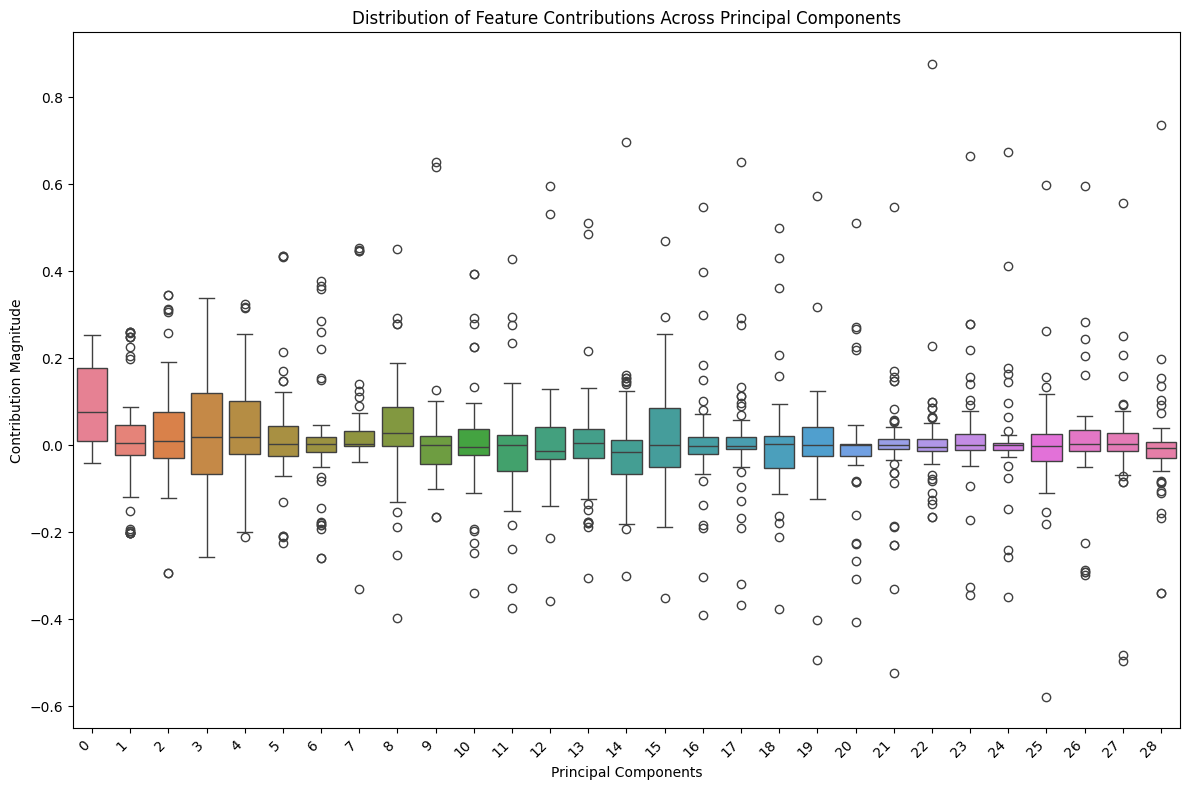

In [66]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=components_df.T)
plt.title('Distribution of Feature Contributions Across Principal Components')
plt.ylabel('Contribution Magnitude')
plt.xlabel('Principal Components')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<ipython-input-67-67e7fb0532b6>:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(reduced_data_2d[:, 0], reduced_data_2d[:, 1], alpha=0.7, cmap='viridis')


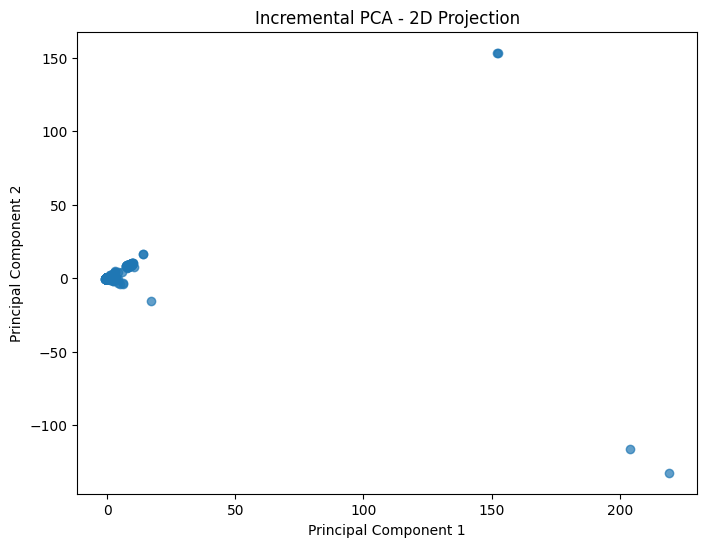

In [67]:
# Transform Data to 2D Using the First Two Components
reduced_data_2d = ipca.transform(scaled_features)[:, :2]

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data_2d[:, 0], reduced_data_2d[:, 1], alpha=0.7, cmap='viridis')
plt.title('Incremental PCA - 2D Projection')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

<ipython-input-68-6040cd814dbb>:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(reduced_data_3d[:, 0], reduced_data_3d[:, 1], alpha=0.7, cmap='viridis')


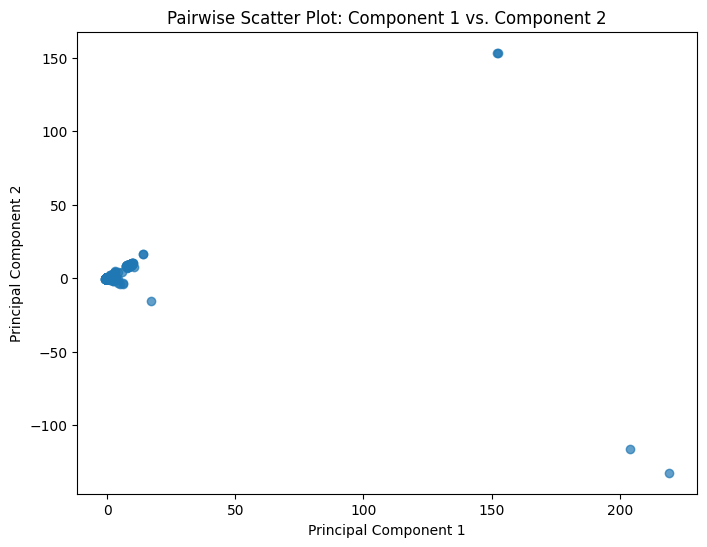

In [68]:
# Transform Data to Top 3 Components
reduced_data_3d = ipca.transform(scaled_features)[:, :3]

plt.figure(figsize=(8, 6))
plt.scatter(reduced_data_3d[:, 0], reduced_data_3d[:, 1], alpha=0.7, cmap='viridis')
plt.title('Pairwise Scatter Plot: Component 1 vs. Component 2')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [69]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Transform Full Dataset with IPCA
reduced_data = ipca.transform(scaled_features)

# Apply K-Means
num_clusters = 2  # Adjust based on the dataset
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(reduced_data)

# Clustering Labels
cluster_labels = kmeans.labels_

# Evaluate with Silhouette Score
silhouette_avg = silhouette_score(reduced_data, cluster_labels)
print(f'Silhouette Score for K-Means on IPCA-Reduced Data: {silhouette_avg:.2f}')

Silhouette Score for K-Means on IPCA-Reduced Data: 0.97


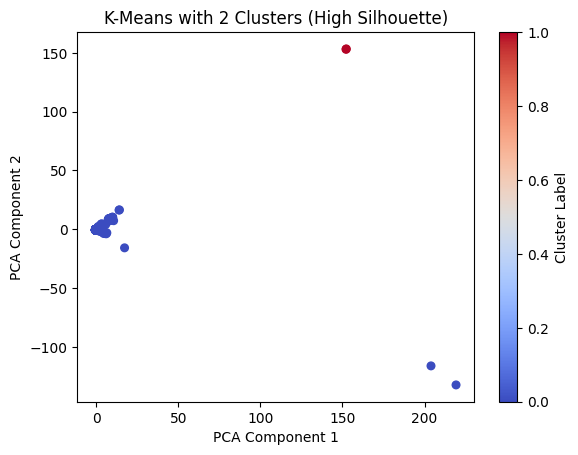

In [70]:
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='coolwarm', s=30)
plt.title('K-Means with 2 Clusters (High Silhouette)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

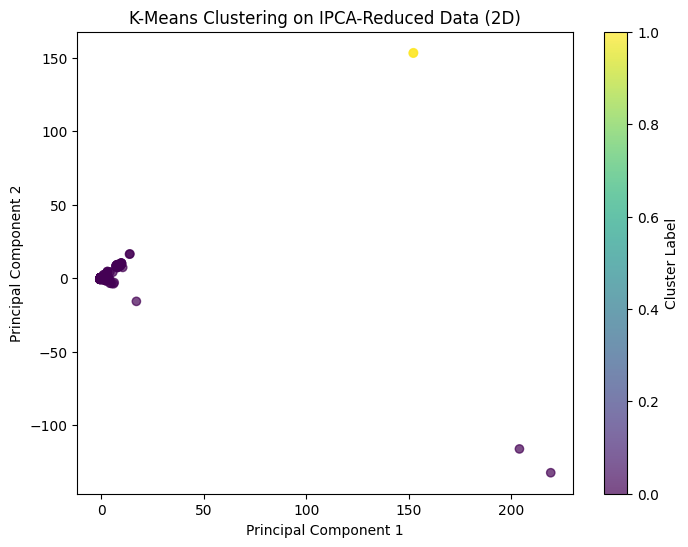

In [71]:
plt.figure(figsize=(8, 6))
plt.scatter(
    reduced_data[:, 0], reduced_data[:, 1],
    c=cluster_labels, cmap='viridis', alpha=0.7
)
plt.title('K-Means Clustering on IPCA-Reduced Data (2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

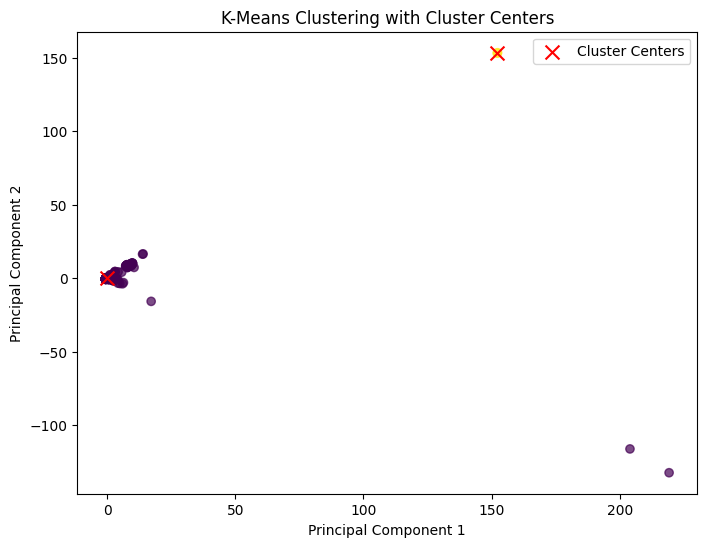

In [72]:
cluster_centers = kmeans.cluster_centers_

plt.figure(figsize=(8, 6))
plt.scatter(
    reduced_data[:, 0], reduced_data[:, 1],
    c=cluster_labels, cmap='viridis', alpha=0.7
)
plt.scatter(
    cluster_centers[:, 0], cluster_centers[:, 1],
    color='red', marker='x', s=100, label='Cluster Centers'
)
plt.title('K-Means Clustering with Cluster Centers')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [73]:
transformed_features = ipca.transform(scaled_features)
new_data = pd.DataFrame(transformed_features, columns = [f'PC{i+1}' for i in range(size)])
new_data['Label'] = attacks.values

In [74]:
new_data

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,Label
0,0.891073,-0.418005,-5.734871,7.230037,4.087792,-1.291024,2.039325,-0.377939,-0.547827,-0.704584,...,2.077533,-0.719586,-0.106990,-0.750013,-1.211995,1.308191,-0.561440,-1.102667,-0.175907,XMasAttack
1,0.861058,-0.000622,-1.720540,4.511270,2.212455,-2.460616,-0.500738,-0.586864,-4.597945,-0.870569,...,-1.102548,1.130841,-0.132076,1.109385,-0.550447,0.415491,-0.074693,-1.403458,-0.570195,XMasAttack
2,0.057556,0.266674,2.071840,0.134166,2.168348,-0.844869,-0.570042,-0.997294,-0.136217,-0.031487,...,-0.959119,0.485998,0.135135,1.200595,-0.600549,0.231540,-0.111833,-1.613938,-0.546926,Benign
3,0.001769,0.157843,1.644190,0.101840,1.672334,-0.263746,0.252878,-1.073891,0.102628,0.012284,...,0.430301,-0.253637,0.188706,-0.138432,-0.224100,-0.280408,0.142176,0.363414,0.007653,Benign
4,152.148880,153.018778,-32.794030,-41.622834,14.662199,8.330614,-2.595322,-0.814327,-3.121009,0.931263,...,1.450905,-0.990890,0.115805,-0.676638,1.138465,-0.496785,0.397360,2.568328,0.573732,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9590,-0.516226,-0.524718,-4.042297,0.011610,-1.303503,-0.124386,-0.857085,0.786739,0.657440,0.072615,...,-0.791849,-0.671436,0.009092,0.038166,-0.145229,0.035132,-0.047080,0.118763,-0.051949,Benign
9591,-0.467141,-0.477502,-3.777731,0.328572,-0.602974,-0.738182,-1.621097,-0.935838,0.460748,0.117103,...,-0.684442,-0.832485,0.081053,0.304225,-0.201657,-0.375659,0.134953,-0.058078,0.076537,Benign
9592,-0.477302,-0.489908,-3.682750,0.245393,-0.624986,-0.713400,-1.618801,-0.911196,0.919637,0.247087,...,-0.713699,-0.774687,-0.002732,0.284949,-0.197001,-0.361752,0.132138,-0.059306,0.074173,Benign
9593,-0.545648,-0.319155,-1.472758,-1.436125,-2.201700,-0.761958,-3.639094,-1.145422,-1.572111,-0.130938,...,0.698877,-0.556201,-0.478647,-0.344931,-0.164820,-0.113742,0.039429,-0.094924,0.032010,Benign


In [75]:
new_data['BinLabel'] = aggregated_data['Label'].apply(lambda x: 0 if x == 'Benign' else 1)

In [76]:
new_data

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,Label,BinLabel
0,0.891073,-0.418005,-5.734871,7.230037,4.087792,-1.291024,2.039325,-0.377939,-0.547827,-0.704584,...,-0.719586,-0.106990,-0.750013,-1.211995,1.308191,-0.561440,-1.102667,-0.175907,XMasAttack,1
1,0.861058,-0.000622,-1.720540,4.511270,2.212455,-2.460616,-0.500738,-0.586864,-4.597945,-0.870569,...,1.130841,-0.132076,1.109385,-0.550447,0.415491,-0.074693,-1.403458,-0.570195,XMasAttack,1
2,0.057556,0.266674,2.071840,0.134166,2.168348,-0.844869,-0.570042,-0.997294,-0.136217,-0.031487,...,0.485998,0.135135,1.200595,-0.600549,0.231540,-0.111833,-1.613938,-0.546926,Benign,0
3,0.001769,0.157843,1.644190,0.101840,1.672334,-0.263746,0.252878,-1.073891,0.102628,0.012284,...,-0.253637,0.188706,-0.138432,-0.224100,-0.280408,0.142176,0.363414,0.007653,Benign,0
4,152.148880,153.018778,-32.794030,-41.622834,14.662199,8.330614,-2.595322,-0.814327,-3.121009,0.931263,...,-0.990890,0.115805,-0.676638,1.138465,-0.496785,0.397360,2.568328,0.573732,Benign,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9590,-0.516226,-0.524718,-4.042297,0.011610,-1.303503,-0.124386,-0.857085,0.786739,0.657440,0.072615,...,-0.671436,0.009092,0.038166,-0.145229,0.035132,-0.047080,0.118763,-0.051949,Benign,0
9591,-0.467141,-0.477502,-3.777731,0.328572,-0.602974,-0.738182,-1.621097,-0.935838,0.460748,0.117103,...,-0.832485,0.081053,0.304225,-0.201657,-0.375659,0.134953,-0.058078,0.076537,Benign,0
9592,-0.477302,-0.489908,-3.682750,0.245393,-0.624986,-0.713400,-1.618801,-0.911196,0.919637,0.247087,...,-0.774687,-0.002732,0.284949,-0.197001,-0.361752,0.132138,-0.059306,0.074173,Benign,0
9593,-0.545648,-0.319155,-1.472758,-1.436125,-2.201700,-0.761958,-3.639094,-1.145422,-1.572111,-0.130938,...,-0.556201,-0.478647,-0.344931,-0.164820,-0.113742,0.039429,-0.094924,0.032010,Benign,0


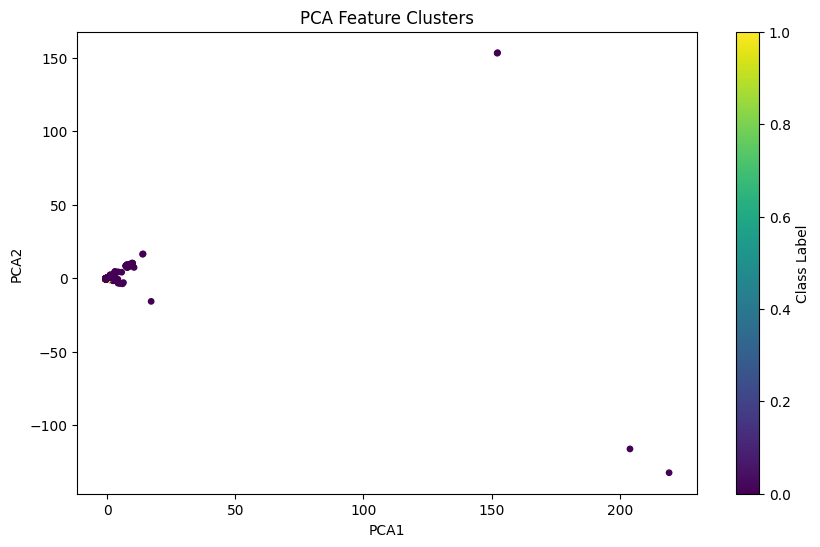

In [77]:
import matplotlib.pyplot as plt

# Visualize pca features
plt.figure(figsize=(10, 6))
scatter = plt.scatter(new_data['PC1'], new_data['PC2'], c=new_data['BinLabel'], cmap='viridis', s=15)
plt.colorbar(scatter, label='Class Label')
plt.title('PCA Feature Clusters')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

In [78]:
import pandas as pd
import numpy as np

# Assuming 'pca_data' contains the PCA-transformed data with principal components and labels
# Columns: ['PCA1', 'PCA2', 'PCA3', ..., 'Label']

# Original features and PCA components from the PCA object
features = ['total_forward_packets_window',
       'total_backward_packets_window', 'total_forward_bytes_window',
       'total_backward_bytes_window', 'average_packet_size_fwd_window',
       'average_packet_size_bwd_window', 'flow_duration_window',
       'packet_count_window', 'mean_iat_fwd_window', 'stddev_iat_fwd_window',
       'min_iat_fwd_window', 'max_iat_fwd_window', 'mean_iat_bwd_window',
       'stddev_iat_bwd_window', 'min_iat_bwd_window', 'max_iat_bwd_window',
       'flow_rate_packets_window', 'flow_rate_bytes_window',
       'flow_direction_ratio_window', 'byte_direction_ratio_window',
       'src_ip_entropy_window', 'dst_ip_entropy_window',
       'src_port', 'dst_port', 'protocol', 'flow_duration',
       'total_forward_packets', 'total_backward_packets',
       'total_bytes_forward', 'total_bytes_backward',
       'mean_packet_length_forward', 'mean_packet_length_backward',
       'packet_size_mean', 'flow_iat_mean', 'down_up_ratio',
       'subflow_fwd_pkts', 'subflow_bwd_pkts', 'subflow_fwd_byts',
       'subflow_bwd_byts', 'fwd_pkt_len_mean', 'fwd_pkt_len_max',
       'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_iat_mean', 'fwd_iat_max',
       'fwd_iat_min', 'fwd_iat_tot', 'fwd_blk_rate_avg', 'bwd_pkt_len_mean',
       'bwd_pkt_len_max', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_iat_mean',
       'bwd_iat_max', 'bwd_iat_min', 'bwd_iat_tot', 'bwd_blk_rate_avg',
       'total_packets', 'total_bytes']  # Replace with actual feature names

pca_components = ipca.components_[:3]  # First 3 principal components

# Initialize a DataFrame to store loadings
loadings_df = pd.DataFrame(pca_components.T, columns=['PC1', 'PC2', 'PC3'], index=features)

# Group data by class and calculate class-specific means
grouped_data = new_data.groupby('Label').mean()

# For each class, compute feature loadings
for label in grouped_data.index:
    print(f"Feature Loadings for Class {label}:")

    # Combine feature names and loadings for the first 3 PCs
    class_loadings = pd.DataFrame({
        'Feature': features,
        'PC1 Loading': loadings_df['PC1'].values,
        'PC2 Loading': loadings_df['PC2'].values,
        'PC3 Loading': loadings_df['PC3'].values
    })

    # Display the result
    print(class_loadings)
    print("\n")

Feature Loadings for Class Benign:
                           Feature  PC1 Loading  PC2 Loading  PC3 Loading
0     total_forward_packets_window     0.021033    -0.019115    -0.005327
1    total_backward_packets_window     0.114174    -0.120006     0.005125
2       total_forward_bytes_window     0.011422    -0.009182     0.004919
3      total_backward_bytes_window     0.111678    -0.117496     0.005667
4   average_packet_size_fwd_window     0.007565     0.026531     0.305111
5   average_packet_size_bwd_window     0.027492     0.005914     0.018063
6             flow_duration_window     0.010548     0.001895     0.044114
7              packet_count_window    -0.003992    -0.024674    -0.294521
8              mean_iat_fwd_window     0.007527     0.018118     0.192062
9            stddev_iat_fwd_window     0.006511     0.014251     0.188790
10              min_iat_fwd_window     0.002545     0.004986     0.055605
11              max_iat_fwd_window     0.002710     0.000573     0.035801
12 

In [79]:
class_loadings['Total Contribution'] = (
    class_loadings['PC1 Loading'].abs() +
    class_loadings['PC2 Loading'].abs() +
    class_loadings['PC3 Loading'].abs()
)

# Sort features by their total contribution
ranked_features = class_loadings.sort_values(by='Total Contribution', ascending=False)

# Display the top N features contributing to the class
top_features = ranked_features.head(10)  # Adjust the number as needed
print(f"Top Features Contributing to Class Prediction:")
print(top_features[['Feature', 'Total Contribution']])

Top Features Contributing to Class Prediction:
             Feature  Total Contribution
40   fwd_pkt_len_max            0.483375
25     flow_duration            0.467898
46       fwd_iat_tot            0.467815
55       bwd_iat_tot            0.467692
52      bwd_iat_mean            0.466955
43      fwd_iat_mean            0.465487
33     flow_iat_mean            0.462052
51   bwd_pkt_len_std            0.456943
53       bwd_iat_max            0.431704
39  fwd_pkt_len_mean            0.428720


In [80]:
# Define the class of interest (e.g., 'benign')
class_of_interest = "Benign"

# Initialize a DataFrame to store loadings
loadings_df = pd.DataFrame(pca_components.T, columns=['PC1', 'PC2', 'PC3'], index=features)

# Group data by class and calculate class-specific means
grouped_data = new_data.groupby('Label').mean()

# For each class, compute feature loadings
for label in grouped_data.index:
    if label == class_of_interest:  # Process only the class of interest
        print(f"Feature Loadings for Class {label}:")

        # Combine feature names and loadings for the first 3 PCs
        class_loadings = pd.DataFrame({
            'Feature': features,
            'PC1 Loading': loadings_df['PC1'].values,
            'PC2 Loading': loadings_df['PC2'].values,
            'PC3 Loading': loadings_df['PC3'].values
        })

        # Calculate an overall importance score (absolute sum of loadings across PCs)
        class_loadings['Importance Score'] = class_loadings[['PC1 Loading', 'PC2 Loading', 'PC3 Loading']].abs().sum(axis=1)

        # Sort features by importance score in descending order
        sorted_features = class_loadings.sort_values(by='Importance Score', ascending=False)

        # Display the top features
        print(sorted_features.head(10))  # Display top 10 features

Feature Loadings for Class Benign:
             Feature  PC1 Loading  PC2 Loading  PC3 Loading  Importance Score
40   fwd_pkt_len_max     0.169757     0.226131     0.087487          0.483375
25     flow_duration     0.148317     0.248517    -0.071064          0.467898
46       fwd_iat_tot     0.148428     0.248493    -0.070895          0.467815
55       bwd_iat_tot     0.148316     0.248478    -0.070898          0.467692
52      bwd_iat_mean     0.153479     0.259457    -0.054019          0.466955
43      fwd_iat_mean     0.156981     0.260823    -0.047683          0.465487
33     flow_iat_mean     0.152870     0.258718    -0.050464          0.462052
51   bwd_pkt_len_std     0.184650     0.204710    -0.067583          0.456943
53       bwd_iat_max     0.153796     0.260397    -0.017512          0.431704
39  fwd_pkt_len_mean     0.035344     0.048973     0.344403          0.428720


In [81]:
print(class_loadings.columns)

Index(['Feature', 'PC1 Loading', 'PC2 Loading', 'PC3 Loading',
       'Importance Score'],
      dtype='object')


In [82]:
class_loadings.head()

,Feature,PC1 Loading,PC2 Loading,PC3 Loading,Importance Score
0,total_forward_packets_window,0.021033,-0.019115,-0.005327,0.045475
1,total_backward_packets_window,0.114174,-0.120006,0.005125,0.239305
2,total_forward_bytes_window,0.011422,-0.009182,0.004919,0.025523
3,total_backward_bytes_window,0.111678,-0.117496,0.005667,0.234841
4,average_packet_size_fwd_window,0.007565,0.026531,0.305111,0.339207


In [83]:
# Unique class labels
class_labels = new_data['Label'].unique()

# Dictionary to store top features for each class
class_specific_top_features = {}

for label in class_labels:
    # Filter loadings for the current class
    class_data = new_data[new_data['Label'] == label]

    # Compute total contribution
    class_loadings['Total Contribution'] = (
    class_loadings['PC1 Loading'].abs() +
    class_loadings['PC2 Loading'].abs() +
    class_loadings['PC3 Loading'].abs()
)

    # Sort features by their contribution
    ranked_features = class_loadings.sort_values(by='Total Contribution', ascending=False)

    # Store the top 10 features for the current class
    class_specific_top_features[label] = ranked_features.head(10)  # Adjust the number as needed

# Print top features for each class
for label, top_features in class_specific_top_features.items():
    print(f"Top Features Contributing to Prediction for Class '{label}':")
    print(top_features[['Feature', 'Total Contribution']])
    print("\n")

Top Features Contributing to Prediction for Class 'XMasAttack':
             Feature  Total Contribution
40   fwd_pkt_len_max            0.483375
25     flow_duration            0.467898
46       fwd_iat_tot            0.467815
55       bwd_iat_tot            0.467692
52      bwd_iat_mean            0.466955
43      fwd_iat_mean            0.465487
33     flow_iat_mean            0.462052
51   bwd_pkt_len_std            0.456943
53       bwd_iat_max            0.431704
39  fwd_pkt_len_mean            0.428720


Top Features Contributing to Prediction for Class 'Benign':
             Feature  Total Contribution
40   fwd_pkt_len_max            0.483375
25     flow_duration            0.467898
46       fwd_iat_tot            0.467815
55       bwd_iat_tot            0.467692
52      bwd_iat_mean            0.466955
43      fwd_iat_mean            0.465487
33     flow_iat_mean            0.462052
51   bwd_pkt_len_std            0.456943
53       bwd_iat_max            0.431704
39  fwd_pkt_l

In [84]:
# Filter data for the Benign class
benign_data = new_data[new_data['Label'] == 'Benign']

# Compute total contribution for features in the Benign class
benign_loadings = class_loadings.copy()  # Ensure we're working on a fresh copy

benign_loadings['Total Contribution'] = (
    benign_loadings['PC1 Loading'].abs() +
    benign_loadings['PC2 Loading'].abs() +
    benign_loadings['PC3 Loading'].abs()
)

# Sort features by their contribution
ranked_benign_features = benign_loadings.sort_values(by='Total Contribution', ascending=False)

# Store the top 10 features for the Benign class
top_features_benign = ranked_benign_features.head(10)

# Print the top features for the Benign class
print("Top Features Contributing to Prediction for Class 'Benign':")
print(top_features_benign[['Feature', 'Total Contribution']])

Top Features Contributing to Prediction for Class 'Benign':
             Feature  Total Contribution
40   fwd_pkt_len_max            0.483375
25     flow_duration            0.467898
46       fwd_iat_tot            0.467815
55       bwd_iat_tot            0.467692
52      bwd_iat_mean            0.466955
43      fwd_iat_mean            0.465487
33     flow_iat_mean            0.462052
51   bwd_pkt_len_std            0.456943
53       bwd_iat_max            0.431704
39  fwd_pkt_len_mean            0.428720


In [85]:
# t-SNE feature engineering

In [86]:
from sklearn.manifold import TSNE

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
tsne_features = tsne.fit_transform(scaled_features)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [87]:
# Create a DataFrame with t-SNE features
tsne_data = pd.DataFrame(tsne_features, columns=['t-SNE1', 't-SNE2'])
tsne_data['Label'] = attacks.values

In [88]:
tsne_data['BinLabel'] = aggregated_data['Label'].apply(lambda x: 0 if x == 'Benign' else 1)

In [89]:
tsne_data

,t-SNE1,t-SNE2,Label,BinLabel
0,-5.699664,8.287932,XMasAttack,1
1,-7.707283,9.378463,XMasAttack,1
2,-4.246231,-8.029442,Benign,0
3,-5.119783,-6.099957,Benign,0
4,-13.287247,-0.036404,Benign,0
...,...,...,...,...
9590,8.439123,9.898355,Benign,0
9591,10.364451,6.289618,Benign,0
9592,10.294228,6.294736,Benign,0
9593,2.234154,-12.147429,Benign,0


In [90]:
# t-SNE Visualization

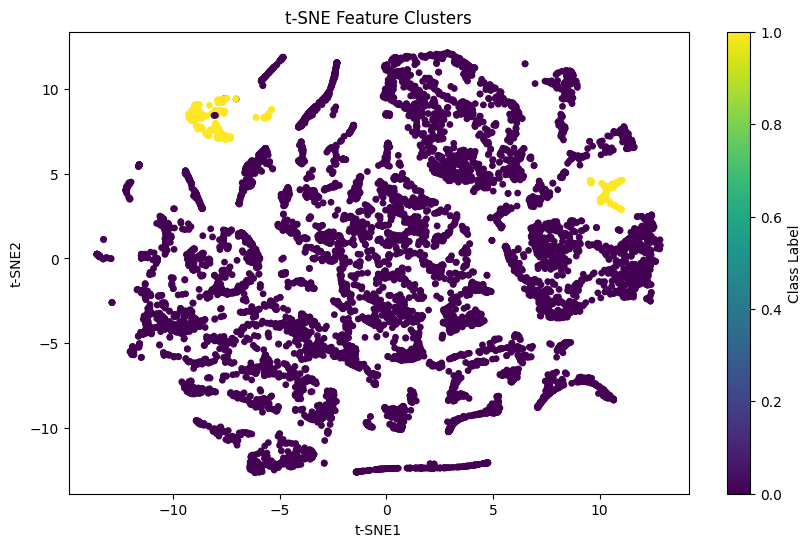

In [91]:
import matplotlib.pyplot as plt

# Visualize t-SNE features
plt.figure(figsize=(10, 6))
scatter = plt.scatter(tsne_data['t-SNE1'], tsne_data['t-SNE2'], c=tsne_data['BinLabel'], cmap='viridis', s=15)
plt.colorbar(scatter, label='Class Label')
plt.title('t-SNE Feature Clusters')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.show()

In [92]:
#Assess Clustering Relevance for t-SNE

In [93]:
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.cluster import KMeans

# Apply K-Means clustering on t-SNE features
kmeans = KMeans(n_clusters=len(tsne_data['BinLabel'].unique()), random_state=42)
cluster_labels = kmeans.fit_predict(tsne_data[['t-SNE1', 't-SNE2']])

# Compute metrics
sil_score = silhouette_score(tsne_data[['t-SNE1', 't-SNE2']], cluster_labels)
ari_score = adjusted_rand_score(tsne_data['BinLabel'], cluster_labels)

print(f'Silhouette Score: {sil_score:.2f}')
print(f'Adjusted Rand Index (ARI): {ari_score:.2f}')

Silhouette Score: 0.35
Adjusted Rand Index (ARI): 0.00


In [94]:
# Supervised Models - Model training on PCA transformed data

In [95]:
from sklearn.model_selection import train_test_split

X_bin_class = new_data.drop(columns=['Label','BinLabel'], axis = 1)
y_bin_class = new_data['BinLabel']

X_train_bin_class, X_test_bin_class, y_train_bin_class, y_test_bin_class = train_test_split(X_bin_class, y_bin_class, test_size = 0.25, random_state = 0)


In [96]:
# Alternatively, check if any NaNs exist
print(X_bin_class.isna().any().any())  # Returns True if any NaN values exist

False


In [97]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

In [98]:
# Random forest classfier for binary

In [99]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_bin_class, y_train_bin_class)

RandomForestClassifier(random_state=42)

In [100]:
# Perform 5-fold cross-validation
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(rf, X_train_bin_class,y_train_bin_class, cv=5, scoring='accuracy')

# Calculate the mean and standard deviation of the accuracy across the folds
print(f"Cross-validated accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

Cross-validated accuracy: 0.9993 (+/- 0.0006)


In [101]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [102]:
# Predict on the test set
y_pred = rf.predict(X_test_bin_class)

In [103]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_bin_class, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[2301    1]
 [   0   97]]


In [104]:
# Generate classification report
report = classification_report(y_test_bin_class, y_pred, target_names=['Benign', 'Attack'])
print("Classification Report:")
print(report)

# Specificity calculation
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.4f}")

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      2302
      Attack       0.99      1.00      0.99        97

    accuracy                           1.00      2399
   macro avg       0.99      1.00      1.00      2399
weighted avg       1.00      1.00      1.00      2399

Specificity: 0.9996


In [105]:
# Support vector for binary classification

In [106]:
from sklearn.svm import SVC
svm = SVC(kernel = 'poly', C = 1, random_state = 0, probability = True)
svm.fit(X_train_bin_class, y_train_bin_class)

SVC(C=1, kernel='poly', probability=True, random_state=0)

In [107]:
# Perform 5-fold cross-validation
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(svm, X_train_bin_class,y_train_bin_class, cv=5, scoring='accuracy')

# Calculate the mean and standard deviation of the accuracy across the folds
print(f"Cross-validated accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

Cross-validated accuracy: 0.9994 (+/- 0.0005)


In [108]:
# Train the SVM model on the training set
svm.fit(X_train_bin_class, y_train_bin_class)
# Predict on the test set
y_pred_svm = svm.predict(X_test_bin_class)

In [109]:
# Compute confusion matrix for SVM
conf_matrix = confusion_matrix(y_test_bin_class, y_pred_svm)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[2301    1]
 [   0   97]]


In [110]:
# Generate classification report
report = classification_report(y_test_bin_class, y_pred_svm, target_names=['Benign', 'Attack'])
print("Classification Report:")
print(report)

# Specificity calculation
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.4f}")

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      2302
      Attack       0.99      1.00      0.99        97

    accuracy                           1.00      2399
   macro avg       0.99      1.00      1.00      2399
weighted avg       1.00      1.00      1.00      2399

Specificity: 0.9996


In [111]:
# # XGBoost for binary classification

In [112]:
from xgboost import XGBClassifier
import xgboost as xgb

In [113]:
# Convert training data to DMatrix with feature names
dtrain = xgb.DMatrix(X_train_bin_class, label=y_train_bin_class, feature_names=[f"feature_{i}" for i in range(X_train_bin_class.shape[1])])

In [114]:
X_train_bin_class.shape

(7196, 29)

In [115]:
params = {
    'objective': 'binary:logistic',
    'learning_rate': 0.1,
    'max_depth': 6,
    'random_state': 42
    }

In [116]:
# Train the model
xgb_model = xgb.train(params, dtrain=dtrain)

In [117]:
# Make predictions (use DMatrix for the test data if available)
dtest = xgb.DMatrix(X_test_bin_class, feature_names=[f"feature_{i}" for i in range(X_test_bin_class.shape[1])])  # Use your actual test dataset instead of X for real predictions
y_pred = xgb_model.predict(dtest)

In [118]:
# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

In [119]:
# Evaluate the model
from sklearn.metrics import confusion_matrix, accuracy_score
accuracy = accuracy_score(y_test_bin_class, y_pred_binary)  # Compare with binary predictions
conf_matrix = confusion_matrix(y_test_bin_class, y_pred_binary)

In [120]:
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.9983
Confusion Matrix:
 [[2302    0]
 [   4   93]]


In [121]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test_bin_class, y_pred_binary))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2302
           1       1.00      0.96      0.98        97

    accuracy                           1.00      2399
   macro avg       1.00      0.98      0.99      2399
weighted avg       1.00      1.00      1.00      2399



In [122]:
# Feed forward Neural Network for binary classification

In [123]:
from keras.models import Sequential
from keras.layers import Dense, Input
from tensorflow.keras.layers import Dropout

feedforward_model_bin = Sequential([
    Input(shape=(X_train_bin_class.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),  # Dropout layer for regularization
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

In [124]:
feedforward_model_bin.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [125]:
history = feedforward_model_bin.fit(X_train_bin_class, y_train_bin_class, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8752 - loss: 0.3105 - val_accuracy: 0.9986 - val_loss: 0.0168
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9918 - loss: 0.0277 - val_accuracy: 1.0000 - val_loss: 0.0028
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9979 - loss: 0.0088 - val_accuracy: 0.9993 - val_loss: 0.0013
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9993 - loss: 0.0055 - val_accuracy: 0.9993 - val_loss: 0.0013
Epoch 5/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9995 - loss: 0.0043 - val_accuracy: 0.9993 - val_loss: 0.0013
Epoch 6/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9996 - loss: 0.0036 - val_accuracy: 0.9993 - val_loss: 0.0012
Epoch 7/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9997 - loss: 0.0026 - val_accuracy: 0.9993 - val_loss: 0.0012
Epoch 8/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9977 - loss: 0.0055 - val_accuracy: 0.

In [126]:
loss, accuracy = feedforward_model_bin.evaluate(X_test_bin_class, y_test_bin_class)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0026
Test Loss: 0.004369769245386124, Test Accuracy: 0.9991663098335266


In [127]:
y_pred_fnn = (feedforward_model_bin.predict(X_test_bin_class) > 0.5).astype(int)

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [128]:
conf_matrix = confusion_matrix(y_test_bin_class, y_pred_fnn)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[2300    2]
 [   0   97]]


In [129]:
print("Classification Report:")
print(classification_report(y_test_bin_class, y_pred_fnn))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2302
           1       0.98      1.00      0.99        97

    accuracy                           1.00      2399
   macro avg       0.99      1.00      0.99      2399
weighted avg       1.00      1.00      1.00      2399



In [130]:
feedforward_model_bin.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           1,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,101 (47.27 KB)

 Trainable params: 4,033 (15.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,068 (31.52 KB)

In [131]:
# Multi-class detection

In [132]:
features = new_data.drop(columns=['Label', 'BinLabel'], axis = 1)
labels = new_data['Label']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.25, random_state = 0)

In [133]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [134]:
from sklearn.model_selection import cross_val_score
# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')

# Calculate the mean and standard deviation of the accuracy across the folds
print(f"Cross-validated accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

Cross-validated accuracy: 0.9939 (+/- 0.0010)


In [135]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Train the Random Forest model on the training set
rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf.predict(X_test)

In [136]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[2302    0    0    0    0]
 [   0    6   18    0    0]
 [   0    3   32    0    0]
 [   0    0    0   26    0]
 [   0    0    0    0   12]]


In [137]:
# Generate classification report
report = classification_report(y_test, y_pred_rf, target_names=['Benign', 'HTTPAttack', 'TCPAttack', 'UDPAttack', 'XMasAttack'])
print("Random Forest Classifier")

print(report)

#Specificity calculation
#tn, fp, fn, tp = conf_matrix.ravel()
#specificity = tn / (tn + fp)
#print(f"Specificity: {specificity:.4f}")

Random Forest Classifier
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      2302
  HTTPAttack       0.67      0.25      0.36        24
   TCPAttack       0.64      0.91      0.75        35
   UDPAttack       1.00      1.00      1.00        26
  XMasAttack       1.00      1.00      1.00        12

    accuracy                           0.99      2399
   macro avg       0.86      0.83      0.82      2399
weighted avg       0.99      0.99      0.99      2399



In [138]:
# SVM for multi classification

In [139]:
from sklearn.svm import SVC
#from sklearn.multiclass import OneVsRestClassifier
svm_multi = SVC(kernel = 'rbf', C = 1, gamma = 0.1, random_state = 0, probability = True)
svm_multi.fit(X_train, y_train)

SVC(C=1, gamma=0.1, probability=True, random_state=0)

In [140]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(svm_multi, X_train, y_train, cv=5, scoring='accuracy')

# Calculate the mean and standard deviation of the accuracy across the folds
print(f"Cross-validated accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

Cross-validated accuracy: 0.9910 (+/- 0.0008)


In [141]:
# Train the SVM model on the training set
svm_multi.fit(X_train, y_train)

# Predict on the test set
y_pred_svm_multi = svm_multi.predict(X_test)

In [142]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_svm_multi)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[2302    0    0    0    0]
 [   0    2   22    0    0]
 [   0    1   34    0    0]
 [   2    0    0   24    0]
 [   1    0    0    0   11]]


In [143]:
# Generate classification report
report = classification_report(y_test, y_pred_svm_multi, target_names=['Benign', 'HTTPAttack', 'TCPAttack', 'UDPAttack', 'XMasAttack'])
print("SVM Classifier")
print(report)

# Specificity calculation
#tn, fp, fn, tp = conf_matrix.ravel()
#specificity = tn / (tn + fp)
#print(f"Specificity: {specificity:.4f}")

SVM Classifier
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      2302
  HTTPAttack       0.67      0.08      0.15        24
   TCPAttack       0.61      0.97      0.75        35
   UDPAttack       1.00      0.92      0.96        26
  XMasAttack       1.00      0.92      0.96        12

    accuracy                           0.99      2399
   macro avg       0.85      0.78      0.76      2399
weighted avg       0.99      0.99      0.99      2399



In [144]:
# feed forward for Multi classification

In [145]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split

# Convert y1 from object to integer labels
label_encoder = LabelEncoder()
y1_encoded = label_encoder.fit_transform(y_train)

# Convert integer labels to one-hot encoded format for multi-class classification
y1_categorical = to_categorical(y1_encoded)

In [146]:
from keras.models import Sequential
from keras.layers import Dense, Input
from tensorflow.keras.layers import Dropout
# Split the data into training and test sets (80% train, 20% test)
X_train_multi_nn, X_test_multi_nn, y_train_multi_nn, y_test_multi_nn = train_test_split(X_train, y1_categorical, test_size=0.2, random_state=42)

In [147]:
from keras.models import Sequential
from keras.layers import Dense, Input
from tensorflow.keras.layers import Dropout
feedforward_model = Sequential([
    Input(shape=(X_train_multi_nn.shape[1],)),  # Specify the input shape here
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y1_categorical.shape[1], activation='softmax')  # Number of classes in the output layer
])

In [148]:
feedforward_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [149]:
feedforward_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 128)                 │           3,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,421 (48.52 KB)

 Trainable params: 12,421 (48.52 KB)

 Non-trainable params: 0 (0.00 B)

In [150]:
history = feedforward_model.fit(X_train_multi_nn, y_train_multi_nn, epochs=20, batch_size=32, validation_data=(X_test_multi_nn, y_test_multi_nn))

Epoch 1/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8428 - loss: 0.5711 - val_accuracy: 0.9889 - val_loss: 0.0308
Epoch 2/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9835 - loss: 0.0423 - val_accuracy: 0.9958 - val_loss: 0.0157
Epoch 3/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9894 - loss: 0.0264 - val_accuracy: 0.9903 - val_loss: 0.0155
Epoch 4/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9909 - loss: 0.0212 - val_accuracy: 0.9937 - val_loss: 0.0136
Epoch 5/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9902 - loss: 0.0190 - val_accuracy: 0.9958 - val_loss: 0.0137
Epoch 6/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9929 - loss: 0.0167 - val_accuracy: 0.9958 - val_loss: 0.0136
Epoch 7/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9932 - loss: 0.0134 - val_accuracy: 0.9917 - val_loss: 0.0158
Epoch 8/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9941 - loss: 0.0126 - val_accuracy: 0.

In [151]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

In [152]:
y_pred_proba = feedforward_model.predict(X_test_multi_nn)  # Probability predictions for each class
y_pred_ff = np.argmax(y_pred_proba, axis=1)  # Convert to class labels

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [153]:
y_test_ff = np.argmax(y_test_multi_nn, axis=1)

In [154]:
conf_matrix = confusion_matrix(y_test_ff, y_pred_ff)

In [155]:
target_names = ['Benign', 'HTTPAttack', 'TCPAttack', 'UDPAttack', 'XMasAttack']  # Customize based on your classes
report = classification_report(y_test_ff, y_pred_ff, target_names=target_names)

In [156]:
print("Confusion Matrix:")
print(conf_matrix)
print("\nFeed Forward Classifier")
print(report)


Confusion Matrix:
[[1397    0    0    1    1]
 [   0    0    4    0    0]
 [   0    2   12    0    0]
 [   0    0    0   15    0]
 [   0    0    0    0    8]]

Feed Forward Classifier
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      1399
  HTTPAttack       0.00      0.00      0.00         4
   TCPAttack       0.75      0.86      0.80        14
   UDPAttack       0.94      1.00      0.97        15
  XMasAttack       0.89      1.00      0.94         8

    accuracy                           0.99      1440
   macro avg       0.72      0.77      0.74      1440
weighted avg       0.99      0.99      0.99      1440



In [157]:
# XGBoost for multi classification

In [158]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

# Encode labels to numeric values
label_encoder = LabelEncoder()
y1_encoded = label_encoder.fit_transform(y_train)

# Split the data into training and test sets (80% train, 20% test)
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_train, y1_encoded, test_size=0.2, random_state=42)

# Initialize and train the XGBoost Classifier without `use_label_encoder`
xgb_multi = xgb.XGBClassifier(objective='multi:softmax', num_class=len(label_encoder.classes_), eval_metric='mlogloss', random_state=42)
xgb_multi.fit(X_train_multi, y_train_multi)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=5, num_parallel_tree=None, ...)

In [159]:
# Perform 5-fold cross-validation
cv_scores_xgb = cross_val_score(xgb_multi, X_train, y1_encoded, cv=5, scoring='accuracy')
print(f"Cross-validated accuracy: {cv_scores_xgb.mean():.4f} (+/- {cv_scores_xgb.std():.4f})")

Cross-validated accuracy: 0.9939 (+/- 0.0018)


In [160]:
# Predict on the test set
y_pred_xgb = xgb_multi.predict(X_test_multi)

In [161]:
# Decode the predictions and true labels back to original label names for reporting
y_pred_labels = label_encoder.inverse_transform(y_pred_xgb)
y_test_labels = label_encoder.inverse_transform(y_test_multi)

In [162]:
# Compute confusion matrix and classification report
conf_matrix_xgb = confusion_matrix(y_test_labels, y_pred_labels, labels=label_encoder.classes_)
report_xgb = classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_)

In [163]:
print("XGBoost Classifier")
print(report_xgb)

XGBoost Classifier
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      1399
  HTTPAttack       0.50      0.75      0.60         4
   TCPAttack       0.92      0.79      0.85        14
   UDPAttack       1.00      1.00      1.00        15
  XMasAttack       0.89      1.00      0.94         8

    accuracy                           1.00      1440
   macro avg       0.86      0.91      0.88      1440
weighted avg       1.00      1.00      1.00      1440



In [164]:
print("Confusion Matrix for XGBoost:")
print(conf_matrix_xgb)

Confusion Matrix for XGBoost:
[[1398    0    0    0    1]
 [   0    3    1    0    0]
 [   0    3   11    0    0]
 [   0    0    0   15    0]
 [   0    0    0    0    8]]
